In [10]:
#基本的引入
import torch
import torchvision#为了转换图片格式
import torch.nn as nn
import torch.nn.functional as F
from pytorchtools import EarlyStopping#为了实现earlystopping
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
#为了minibatch的功能
import torch.utils.data as Data

torch.manual_seed(1)     # reproducible

In [29]:
#首先，找出到底有哪些classes，我发现test的排列顺序比较好，就以这个为模板了
className=[]
for filename in os.listdir(r"./Caltech101/test"):           #listdir的参数是文件夹的路径
    className.append(filename)
#这样我就有一个放class的list了，之后的label就按照这个list一一对应了

In [ ]:
#来自网络，因为在kaggle上的文件夹名称会很乱，所以要把classes按忽略大小写的顺序重新排一下
def case_insensitive_sort(liststring):
    listtemp = [(x.lower(),x) for x in liststring]#将字符串列表，生成元组，（忽略大小写的字符串，字符串）
    listtemp.sort()#对元组排序，因为元组为：（忽略大小写的字符串，字符串），就是按忽略大小写的字符串排序  
    return [x[1] for x in listtemp]#排序完成后，返回原字符串的列表

In [ ]:
# className=case_insensitive_sort(className)
# print(className)
# print(len(className))

In [35]:
#建立一个处理图片的function
def formlabel(folder,className):
    X, y= [], []
    label=0
    
    ## reading images from the directory
    for classes in className:
        print(classes)
        for images in os.listdir(os.path.join(folder, classes)):
            img = cv2.imread(os.path.join(folder, classes, images))
            img = cv2.resize(img, (224,224))
            #事实证明我要先把这个图片转换一下，因为torch的输入一定要channel——first
            img=torchvision.transforms.ToTensor()(img)
            #然后再换成numpy，不然不好最后搞个转换后的list
            img=img.numpy()
            X.append(img)
            #这部分不用，因为我不用one-hot
#             label = np.zeros(3)
#             label[k]=1
            y.append(label)
        label+=1
    #这里的X，y都是numpy array
    X1 = np.array(X)
    y1 = np.array(y)
    #后面会转换成torch处理的格式
    X=torch.from_numpy(X1)
    y=torch.from_numpy(y1)
    return X, y

In [36]:
#先处理train数据
X_train, y_train=formlabel('./Caltech101/train',className)

In [ ]:
#再处理test数据，test数据是最后用来测试的
#X_test,y_test=formlabel('./Caltech101/test',className)

In [ ]:
#最后是evaluation的数据，evaluation的数据是为了调参的
#X_eval, y_eval=formlabel('./Caltech101/eval',className)

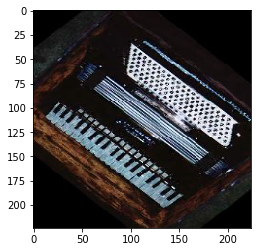

In [38]:
#如果要image show就要先转换成（H,W,C）
#同一文件夹，网络与本地的图片顺序可能不一样，但不会影响training的结果
img=X_train[100]
img = torchvision.transforms.ToPILImage()(img).convert('RGB')
plt.imshow(img)

In [31]:
print(y_train[100])

1


In [48]:
#建立一个minibatch函数
def minibatch(X,y):
    BATCH_SIZE = 50    # mini batch size
    # first transform the data to dataset can be processed by torch
    torch_dataset = Data.TensorDataset(X, y)
    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=2,              # subprocesses for loading data
    )
    return loader

In [ ]:
#CNN
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 224, 224)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 224, 224)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 112, 112)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 112, 112)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 112, 112)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 56, 56)
        )
        self.out = nn.Linear(32 * 56 * 56, 101)   # fully connected layer, output 101 classes

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 56 * 56)
        output = self.out(x)
        return output
       

In [ ]:
#改编版本
def train(model, device, loader, optimizer, epoch,loss_func, log_interval=100):
    model.train()
    for step, (batch_x, batch_y) in enumerate(loader):
        # here to train your model
        X, y = batch_x.to(device),  batch_y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        if step % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:0f}%)]\tLoss: {:.6f}".format(
                epoch,step * len(X), len(loader.dataset), 
                100. * step / len(loader), loss.item()
            ))


In [ ]:
def test(model, device, test_loader,loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss_func(output, y).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
#一些参数
lr = 0.01
momentum = 0.5
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)#这个是和设备GPU/CPU相关的系数。
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_func = nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
train_loader=minibatch(X_train,y_train)
test_loader=minibatch(X_test,y_test)

In [ ]:
epochs =50
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch,loss_func)
    test(model, device, test_loader,loss_func)


In [ ]:
# save_model = True
# if (save_model):
#     torch.save(model.state_dict(),"cnn.pt")